Dieses Notebook berechnet die **Anzahl der Wohnungen** in definierten Einzugsgebieten für **E-Fahrzeug-Ladestationen** in **Winterthur**. Dies geht auf eine Anfrage vom **Umwelt- und Gesundheisschutz** (_UGS_) der Stadtverwaltung Winterthur vom 26.09.2024 zurück. Die Einzugsgebiete wurden vom UGS definiert. Eine genaue Beschreibung der Anfrage findet sich im Ticket [FSTGSM-259].

Im ersten Schritt werden die für diese Berechnung notwendigen Bibliotheken importiert:

In [1]:
import os
from urllib.request import urlretrieve
import zipfile
import geopandas
import pandas
import matplotlib
import contextily

Die vom UGS definierten **Einzugsgebiete** werden aus einer **GeoJSON**-Datei (liegt im Unterordner _input_) als **Anfrage-Polygone** eingelesen:

In [2]:
anfrage_polygone_gdf = geopandas.read_file("input/gebiete_ladestationen.geojson")
anfrage_polygone_gdf.head()

,geometry
0,"POLYGON ((8.71571 47.50593, 8.71674 47.50560, ..."
1,"POLYGON ((8.73614 47.50617, 8.73633 47.50612, ..."
2,"POLYGON ((8.74566 47.49217, 8.74630 47.49188, ..."


Die Anfrage-Polygone liegen im _geographischen_ Koordinatenbezugssystem (_KBS_) **WGS84** vor. Für die Darstellung der Flächen in den _contextily_-Vorschaukarten im Folgenden ist jedoch eine Koordinatentransformation in das _projezierte_ KBS **Spherical Mercator** (_EPSG-Code 3857_) notwendig:

In [3]:
anfrage_polygone_fuer_plot = anfrage_polygone_gdf.to_crs(epsg=3857)

Um im Weiteren **geometrische Operationen** mit den Anfrage-Polygonen durchführen zu können, ist eine Koordinatentransformation in das _projezierte_ Schweizer KBS **LV95** (_EPSG-Code 2056_) notwendig:

In [4]:
anfrage_polygone_gdf = anfrage_polygone_gdf.to_crs(epsg=2056)
anfrage_polygone_gdf.head()

,geometry
0,"POLYGON ((2696210.257 1262468.781, 2696288.413..."
1,"POLYGON ((2697748.918 1262520.604, 2697763.077..."
2,"POLYGON ((2698492.081 1260976.576, 2698540.779..."


Prüfung, ob alle Geometrien der Anfrage-Polygone valide sind:

In [5]:
all(anfrage_polygone_gdf.is_valid)

True

Kartenvorschau der Einzugsgebiete (Anfrage-Polygone) anzeigen:

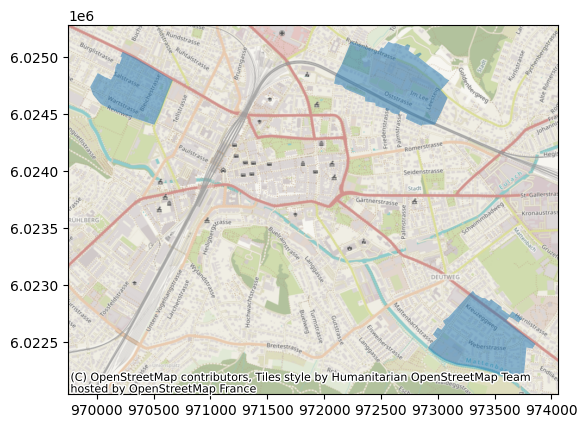

In [6]:
anfrage_polygone_plot = anfrage_polygone_fuer_plot.plot(alpha=0.5)
contextily.add_basemap(anfrage_polygone_plot)

Als Speicher für Zwischenergebnisse soll ein Unterordner "temp" verwendet werden. Falls dieser noch nicht besteht, soll er angelegt werden:

In [7]:
temp_folder = "temp"
if not os.path.exists(temp_folder):
    os.makedirs(temp_folder)

Das **Bundesamt für Statistik** (_BfS_) bietet den Datenbestand des eidgenössischen **Gebäude- und Wohnungsregisters** (_GWR_) über die sog. _MADD-Schnittstelle_ unter der URL https://public.madd.bfs.admin.ch zum Download an. Im folgenden Schritt wird der gesamte Bestand des GWR nur für den **Kanton Zürich** vom BfS herunterladen:

In [8]:
urlretrieve("https://public.madd.bfs.admin.ch/zh.zip", "temp/zh.zip")

('temp/zh.zip', <http.client.HTTPMessage at 0x1f56b1ab440>)

Der Download erfolgte im Archiv-Format ZIP. Das ZIP-Archiv muss entpackt werden, um an die Nutzdaten zu gelangen:

In [9]:
with zipfile.ZipFile("temp/zh.zip", "r") as zh_zip:
    zh_zip.extractall("temp/")

Die Gebäudedaten aus dem GWR liegen in der Datei _buildings.geojson_ vor. Diese werden im Folgeschritt eingelesen:

In [10]:
gwr_gebaeude_zh_gdf = geopandas.read_file("temp/buildings.geojson")
gwr_gebaeude_zh_gdf.head()

,egid,buildingStatus,buildingCategory,buildingClass,municipalityNumber,municipalityName,canton,geometry
0,1,1004,1040,1271,2,Affoltern am Albis,ZH,POINT (2676523.000 1235843.000)
1,10,1004,1020,1110,2,Affoltern am Albis,ZH,POINT (2676440.038 1235973.538)
2,100,1004,1020,1110,2,Affoltern am Albis,ZH,POINT (2676765.706 1236101.658)
3,1000,1007,1030,1110,2,Affoltern am Albis,ZH,POINT (2676644.881 1236812.863)
4,10000,1004,1030,1121,291,Andelfingen,ZH,POINT (2693391.650 1272255.267)


Der Datensatz beinhaltet **alle Gebäude** des **Kantons Zürich**. Als erstes wird auf die Gebäude der **Stadt Winterthur gefiltert**. Winterthur hat die offizielle Gemeindenummer **230**:

In [11]:
gwr_gebaeude_win_gdf = gwr_gebaeude_zh_gdf[gwr_gebaeude_zh_gdf["municipalityNumber"] == 230]
gwr_gebaeude_win_gdf["egid"].count()

np.int64(25944)

Im _Herbst 2024_ gibt es **25'944 Gebäudeobjekte** im GWR-Katalog innerhalb des Stadtgebiets von Winterthur.

Im nächsten Schritt wird auf die **bestehenden Gebäude** im Datensatz gefiltert. Dies ist über die **Codes** am **Status**-Attribut möglich. Die Codes werden im **Merkmalskatalog zum GWR** erläutert. Der Code **1004** hat die Bedeutuung "Gebäude bestehend":

In [12]:
gwr_gebaeude_win_gdf = gwr_gebaeude_win_gdf[gwr_gebaeude_win_gdf["buildingStatus"] == 1004]
gwr_gebaeude_win_gdf["egid"].count()

np.int64(24242)

Im _Herbst 2024_ gibt es **24'242 Gebäude** in Winterthur.

Nun erfolgt der **räumliche Verschnitt** (_intersects_) der **Anfrage-Polygone** mit den **GWR-Gebäuden**, um ausschliesslich die Gebäude im Anfragegebiet (Einzugsgebiete der Ladestationen) herauszufiltern:

In [13]:
gebaeude_im_anfragegebiet = geopandas.sjoin(gwr_gebaeude_win_gdf, anfrage_polygone_gdf, how="inner", predicate="intersects")
gebaeude_im_anfragegebiet.head()

,egid,buildingStatus,buildingCategory,buildingClass,municipalityNumber,municipalityName,canton,geometry,index_right
16175,1150451,1004,1020,1122,230,Winterthur,ZH,POINT (2697527.891 1262283.863),1
16189,1150464,1004,1020,1122,230,Winterthur,ZH,POINT (2697529.718 1262294.984),1
16237,1150508,1004,1020,1122,230,Winterthur,ZH,POINT (2697711.265 1262201.111),1
16238,1150509,1004,1020,1122,230,Winterthur,ZH,POINT (2697702.938 1262207.948),1
16240,1150510,1004,1030,1122,230,Winterthur,ZH,POINT (2697677.405 1262218.854),1


Zur Kontrolle wird das Verschnittergebnis (gefilterte Gebäudemittelpunkte) auf einer Übersichtskarte dargestellt:

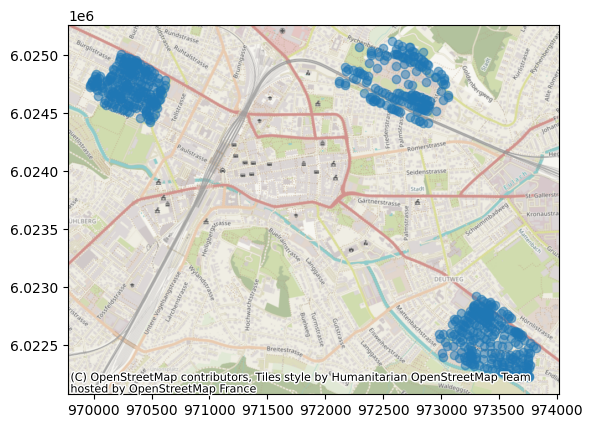

In [14]:
gebaeude_im_anfragegebiet_plot = gebaeude_im_anfragegebiet.to_crs(epsg=3857).plot(alpha=0.5)
contextily.add_basemap(gebaeude_im_anfragegebiet_plot)

Als nächstes werden die Wohnungen aus dem GWR-Datensatz geladen. Diese liegen in der **CSV-Datei** _wohnung_logement_abitazione.csv_ vor:

In [15]:
gwr_wohungen_zh_df = geopandas.read_file("temp/wohnung_logement_abitazione.csv")
gwr_wohungen_zh_df.head()

,EGID,EWID,EDID,WHGNR,WEINR,WSTWK,WBEZ,WMEHRG,WBAUJ,WABBJ,WSTAT,WAREA,WAZIM,WKCHE,WEXPDAT,geometry
0,1,1,0,1,,3100,,1,1999,,3004,40,1,1,2024-10-09,None
1,1,3,0,101,,3101,,0,1999,,3004,120,4,1,2024-10-09,None
2,2,1,0,,,3100,,1,1999,2010,3007,120,5,1,2024-10-09,None
3,3,1,0,,,3100,,1,1999,,3004,144,6,1,2024-10-09,None
4,4,1,0,,,3100,,1,1999,,3004,160,5,1,2024-10-09,None


Dies sind alle Wohnungsobjekte des gesamten Kantons Zürich. Im nächsten Schritt wird auch bei den Wohnungen ausschliesslich auf die **bestehenden Wohnungen** im Datensatz gefiltert. Auch hier ist es über die **Codes** am **Status**-Attribut (_WSTAT_) der Wohnung möglich. Nach **Merkmalskatalog** hat der Code **3004** die Bedeutuung "Wohnung bestehend":

In [16]:
gwr_wohungen_zh_df = gwr_wohungen_zh_df[gwr_wohungen_zh_df["WSTAT"] == "3004"]
gwr_wohungen_zh_df["EGID"].count()

np.int64(797873)

Stand _Herbst 2024_ gibt es insgesamt **797'873 Wohnungen** im Kanton Zürich.

Bei den **Wohnungsdaten** hat das Attribut **Eidgenössischer Gebäudeidentifikator** (_EGID_) noch einen unpassenden Datentyp (_object_). Es handelt sich bei dem Attribut tatsächlich um eine Ganzzahl. Da dieses Attribut in den Operationen der Folgeschritte verwendet wird, wird dieser zunächst in einen **numerischen Datentyp** (_int64_) umgewandelt:

In [17]:
gwr_wohungen_zh_df["EGID"] = pandas.to_numeric(gwr_wohungen_zh_df["EGID"])
gwr_wohungen_zh_df["EGID"].dtype

dtype('int64')

Im finaler Schritt werden die Wohnungen anhand der EGID der Gebäude im Anfragegebiet gefiltert. Es werden also nur noch solche Wohnungen "beibehalten", die im GWR den Gebäuden zugeordnet sind, die in den Anfrage-Polygonen (Einzugsgebiete) liegen:

In [18]:
wohungen_im_anfragegebiet_gesamt = gwr_wohungen_zh_df[gwr_wohungen_zh_df["EGID"].isin(gebaeude_im_anfragegebiet["egid"].tolist())]
wohungen_im_anfragegebiet_gesamt["EGID"].count()

np.int64(1944)

Stand _Herbst 2024_ gibt es **1'944 Wohnungen** in den Anfragegebieten insgesamt (alle Einzugsgebiete der Ladestationen für E-Fahrzeuge).

Der Verschnitt- und Filterprozess wird nun für jedes Teilgebiet der Anfrage-Polygone **wiederholt**, da auch für die Teilgebiete die Anzahl der Wohnungen zu berechnen ist. Dazu wird jeweils ein _GeoDataFrame_ zu jedem Teilgebiet ("Ackeretstrasse 17", "Nordstrasse 4", "Bulingerstrasse 2") erzeugt:

In [19]:
anfrage_polygone_ackeret_gdf = anfrage_polygone_gdf[anfrage_polygone_gdf.index == 0]
anfrage_polygone_nord_gdf = anfrage_polygone_gdf[anfrage_polygone_gdf.index == 1]
anfrage_polygone_bulinger_gdf = anfrage_polygone_gdf[anfrage_polygone_gdf.index == 2]

Als erstes Erfolgt die Berechnung für das Teilgebiet **Ackeretstrasse 17**:

In [20]:
gebaeude_im_anfragegebiet_ackeret = geopandas.sjoin(gwr_gebaeude_win_gdf, anfrage_polygone_ackeret_gdf, how="inner", predicate="intersects")
wohungen_im_anfragegebiet_ackeret = gwr_wohungen_zh_df[gwr_wohungen_zh_df["EGID"].isin(gebaeude_im_anfragegebiet_ackeret["egid"].tolist())]
wohungen_im_anfragegebiet_ackeret["EGID"].count()

np.int64(788)

Es hat **788 Wohnungen** im Anfragegebiet **Ackeretstrasse 17**.

Als zweites Teilgebiet wird **Nordstrasse 4** berechnet:

In [21]:
gebaeude_im_anfragegebiet_nord = geopandas.sjoin(gwr_gebaeude_win_gdf, anfrage_polygone_nord_gdf, how="inner", predicate="intersects")
wohungen_im_anfragegebiet_nord = gwr_wohungen_zh_df[gwr_wohungen_zh_df["EGID"].isin(gebaeude_im_anfragegebiet_nord["egid"].tolist())]
wohungen_im_anfragegebiet_nord["EGID"].count()

np.int64(307)

Es hat **307 Wohnungen** im Anfragegebiet **Nordstrasse 4**.

Zuletzt wird das Teilgebiet **Bulingerstrasse 2** berechnet:

In [22]:
gebaeude_im_anfragegebiet_bulinger = geopandas.sjoin(gwr_gebaeude_win_gdf, anfrage_polygone_bulinger_gdf, how="inner", predicate="intersects")
wohungen_im_anfragegebiet_bulinger = gwr_wohungen_zh_df[gwr_wohungen_zh_df["EGID"].isin(gebaeude_im_anfragegebiet_bulinger["egid"].tolist())]
wohungen_im_anfragegebiet_bulinger["EGID"].count()

np.int64(849)

Es hat **849 Wohnungen** im Anfragegebiet **Bulingerstrasse 2**.